In [1205]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers.recurrent import LSTM,GRU
from tensorflow.keras import Input
from pmdarima.arima import auto_arima
# For creating model and training
from tensorflow.keras.layers import Conv1D, Conv2D,ConvLSTM1D, LSTM, Dense, Dropout, Bidirectional, Concatenate, MultiHeadAttention
from tensorflow.keras.layers import MaxPooling1D, Flatten, Reshape
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.models import Model
from keras import backend as K


In [1165]:
df = pd.read_csv('./processed_data.csv')
print(len(df))

5417


In [1166]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,shifted_adj_close,Adj Close Returns,SMA_50,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,Day Delta
0,2000-12-08,666.666687,715.000000,633.333313,680.000000,562.626587,6696000,976255200,562.626587,1.000000,NaN,NaN,NaN,NaN,3.0
1,2000-12-11,675.000000,680.000000,580.000000,580.000000,479.887451,1272000,976514400,562.626587,1.172414,NaN,NaN,NaN,NaN,1.0
2,2000-12-12,575.000000,621.666687,571.666687,591.666687,489.540344,1068000,976600800,479.887451,0.980282,NaN,NaN,NaN,NaN,1.0
3,2000-12-13,586.666687,608.333313,541.666687,566.666687,468.855591,552000,976687200,489.540344,1.044118,NaN,NaN,NaN,NaN,1.0
4,2000-12-14,561.666687,563.333313,541.666687,558.333313,461.960663,330000,976773600,468.855591,1.014925,NaN,NaN,NaN,NaN,1.0


In [1167]:
np.mean(df["MACDs_8_21_9"]), np.max(df["MACDs_8_21_9"])

(13.189244776337183, 2373.3043667197758)

In [1257]:
look_back = 30
def create_dataset(returns, volume, adj_close, MovingAvg, MACDh, MACDs):
    dataX, dataY = [], []
    dataAvg = []
    for i in range(100, len(returns)-look_back-1):
#         print(MovingAvg[i:i+look_back])
        closeP = adj_close[i+look_back]
        ma3 = np.average(adj_close[i+look_back-3:i+look_back])/closeP
        ma12 = np.average(adj_close[i+look_back-12:i+look_back])/closeP
        ma21 = np.average(adj_close[i+look_back-21:i+look_back])/closeP
        ma30 = np.average(adj_close[i+look_back-30:i+look_back])/closeP
        ma100 = np.average(adj_close[i+look_back-100:i+look_back])/closeP

        a = np.vstack([
            returns[i:i+look_back],
#             MovingAvg[i:i+look_back]/MovingAvg[i]
            np.where(MACDh[i:i+look_back] > MACDs[i:i+look_back],1,-1),
#             dayDelta[i:i+look_back],
#             scaler*Open[i:i+look_back],
#             scaler*Low[i:i+look_back],
#             scaler*High[i:i+look_back],
#             scaler*AdjClose[i:i+look_back],
        ]).T
        dataX.append(a)
        dataY.append(returns[i + look_back])
        dataAvg.append([ma3, ma12, ma21, ma30, ma100])
    return np.array(dataX), np.array(dataAvg), np.array(dataY)

returns, dayDelta, volume = np.array(df["Adj Close Returns"]), np.array(df["Day Delta"]), np.array(df["Volume"])/50000
Open, High, Low, AdjClose = df["Open"].to_numpy(), df["High"].to_numpy(), df["Low"].to_numpy(), df["Adj Close"].to_numpy()
MovingAvg = df["SMA_50"].to_numpy()
MACDh, MACDs = df["MACDh_8_21_9"].to_numpy(), df["MACDs_8_21_9"].to_numpy()
adj_close = df["Adj Close"].to_numpy()

multiX, avgX, dataY = create_dataset(returns, volume, adj_close, MovingAvg, MACDh, MACDs)
singleX = multiX[:,:,0:4]

train_count = 5200

multiX_train, multiX_test = multiX[:train_count], multiX[train_count:]
singleX_train, singleX_test = singleX[:train_count], singleX[train_count:]
dataY_train, dataY_test = dataY[:train_count], dataY[train_count:]
avgX_train, avgX_test = avgX[:train_count], avgX[train_count:]

print(singleX_train.shape, multiX_train.shape, dataY_train.shape)
print(singleX_test.shape)
print(avgX.shape)

(5200, 30, 2) (5200, 30, 2) (5200,)
(86, 30, 2)
(5286, 5)


In [1326]:
def same_sign_index(y_true, y_pred):
    y_prod = (y_true-1)*(y_pred-1)
    return tf.math.count_nonzero(tf.greater(y_prod, 0), dtype=tf.dtypes.float32)/64
mse = tf.keras.losses.MeanSquaredError()
def custom_loss(y_true, y_pred):
    return mse(y_true, y_pred) + 0.01*(1-same_sign_index(y_true, y_pred))

In [1327]:
multiModel = Sequential()
multiModel.add(GRU(16, input_shape=(multiX.shape[1], multiX.shape[2])))
multiModel.add(Dense(1))
multiModel.compile(loss='mse', optimizer='sgd')


# x = Input(shape=(look_back, 3))
# attention_layer = MultiHeadAttention(num_heads=100, key_dim=2)
# attention = attention_layer(x, x)
# lstmed = LSTM(64, return_sequences=False)(attention)
# dense = Dense(1)(lstmed)
# singleModel = Model(inputs=[x], outputs=dense)
# conv1 = Conv2D(8, kernel_size=3, activation='relu',padding='same', input_shape=(look_back, 6))(x)
# merged = Concatenate()([x, conv1])
# lstmed = Bidirectional(LSTM(32, return_sequences=False))(merged)
# merged2 = Concatenate()([Flatten()(x), lstmed])

# conv2 = Conv1D(32, kernel_size=3, padding='same', activation='relu')(lstmed)
# flat = Flatten()(conv2)
# dense = Dense(1)(lstmed)
# singleModel = Model(inputs=[x], outputs=dense)


singleModel = Sequential()
singleModel.add(Input(shape=(look_back, 2)))
# singleModel.add(MultiHeadAttention(num_heads=2, key_dim=2))

singleModel.add(Bidirectional(LSTM(4, return_sequences=True)))
singleModel.add(Bidirectional(LSTM(32, return_sequences=False)))

# singleModel.add((Conv1D(128, kernel_size=5, activation='relu')))
# # singleModel.add(Bidirectional(LSTM(32, return_sequences=True)))
# # singleModel.add(Dropout(0.25))

# # singleModel.add(Bidirectional(LSTM(32, return_sequences=True)))
# singleModel.add((Conv1D(64, kernel_size=3, activation='relu')))
# # singleModel.add(Bidirectional(LSTM(32, return_sequences=False)))
# singleModel.add((Conv1D(64, kernel_size=3, activation='relu')))
# singleModel.add((Conv1D(64, kernel_size=15, activation='relu')))

# singleModel.add(Dropout(0.5))
singleModel.add(Flatten())
singleModel.add(Dense(1, activation='linear'))
K.set_value(model.optimizer.learning_rate, 0.0001)

singleModel.compile(optimizer='sgd', loss=custom_loss, metrics=[same_sign_index])

# singleModel.add(Conv2D(64, kernel_size=3, activation='relu', data_format='channels_last'))
# singleModel.add(Reshape((98, -1)))
    
    
# singleModel.add(Bidirectional(LSTM(32, return_sequences=True)))
# # singleModel.add(Flatten())
# singleModel.add((Conv1D(32, kernel_size=3, activation='relu')))
# singleModel.add(Flatten())
# singleModel.add(Dense(1, activation='linear'))
# # singleModel.compile(optimizer='adam', loss='mse')
# singleModel.compile(optimizer='adam', loss='mse')
singleModel.summary()


Model: "sequential_456"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_203 (Bidirect  (None, 30, 8)            224       
 ional)                                                          
                                                                 
 bidirectional_204 (Bidirect  (None, 64)               10496     
 ional)                                                          
                                                                 
 flatten_109 (Flatten)       (None, 64)                0         
                                                                 
 dense_413 (Dense)           (None, 1)                 65        
                                                                 
Total params: 10,785
Trainable params: 10,785
Non-trainable params: 0
_________________________________________________________________


In [1328]:
# Option 1
# singleModel = Sequential()
# singleModel.add((Conv1D(64, kernel_size=3, activation='relu', input_shape=(look_back, 2))))
# singleModel.add(Bidirectional(LSTM(16, return_sequences=False)))
# singleModel.add(Dense(1, activation='linear'))
# singleModel.compile(optimizer='adam', loss='mse')

# Option 2
# singleModel = Sequential()
# singleModel.add((Conv1D(64, kernel_size=3, activation='relu', input_shape=(look_back, 2))))
# singleModel.add(Bidirectional(LSTM(32, return_sequences=False)))
# singleModel.add(Dense(1, activation='linear'))
# singleModel.compile(optimizer='adam', loss='mse')

# Option 3
# singleModel = Sequential()
# singleModel.add((Conv1D(64, kernel_size=3, activation='relu', input_shape=(look_back, 2))))
# singleModel.add(Bidirectional(LSTM(32, return_sequences=False)))
# singleModel.add((Conv1D(32, kernel_size=3, activation='relu')))
# singleModel.add(Flatten())
# singleModel.add(Dense(1, activation='linear'))
# singleModel.compile(optimizer='adam', loss='mse')

In [1329]:

# singleModel = Sequential()

# # Creating the Neural Network model here...
# # CNN layers
# singleModel.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(look_back, 1))))
# singleModel.add(TimeDistributed(MaxPooling1D(2)))
# singleModel.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
# singleModel.add(TimeDistributed(MaxPooling1D(2)))
# singleModel.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
# singleModel.add(TimeDistributed(MaxPooling1D(2)))
# singleModel.add(TimeDistributed(Flatten()))
# # model.add(Dense(5, kernel_regularizer=L2(0.01)))

# # LSTM layers
# singleModel.add(Bidirectional(LSTM(look_back, return_sequences=True)))
# singleModel.add(Dropout(0.5))
# singleModel.add(Bidirectional(LSTM(look_back, return_sequences=False)))
# singleModel.add(Dropout(0.5))

# #Final layers
# singleModel.add(Dense(1, activation='linear'))
# singleModel.compile(optimizer='adam', loss='mse')

# # history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

In [1330]:
history=singleModel.fit(singleX_train, dataY_train, validation_data=(singleX_test, dataY_test), batch_size=64, epochs=40, shuffle=True)

Epoch 1/40
82/82 [==============================] - 8s 35ms/step - loss: 0.0817 - same_sign_index: 0.4571 - val_loss: 0.0085 - val_same_sign_index: 0.2891
Epoch 2/40
82/82 [==============================] - 2s 20ms/step - loss: 0.0066 - same_sign_index: 0.4484 - val_loss: 0.0079 - val_same_sign_index: 0.3125
Epoch 3/40
82/82 [==============================] - 2s 21ms/step - loss: 0.0063 - same_sign_index: 0.4491 - val_loss: 0.0080 - val_same_sign_index: 0.2969
Epoch 4/40
82/82 [==============================] - 2s 22ms/step - loss: 0.0062 - same_sign_index: 0.4451 - val_loss: 0.0080 - val_same_sign_index: 0.2891
Epoch 5/40
82/82 [==============================] - 2s 23ms/step - loss: 0.0062 - same_sign_index: 0.4449 - val_loss: 0.0077 - val_same_sign_index: 0.3047
Epoch 6/40
82/82 [==============================] - 2s 25ms/step - loss: 0.0061 - same_sign_index: 0.4466 - val_loss: 0.0078 - val_same_sign_index: 0.2969
Epoch 7/40
82/82 [==============================] - 2s 25ms/step - los

<AxesSubplot:>

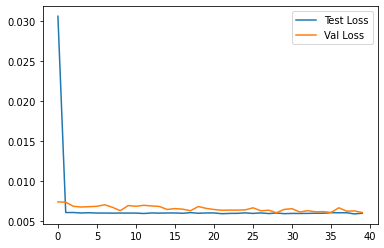

In [1310]:
loss_df = pd.DataFrame()
loss_df["Test Loss"] = history.history['loss']
loss_df["Val Loss"] = history.history['val_loss']
loss_df = loss_df[:]
loss_df.plot()

<AxesSubplot:>

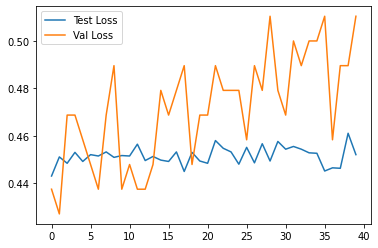

In [1308]:
sign_df = pd.DataFrame()
sign_df["Test Loss"] = history.history['same_sign_index']
sign_df["Val Loss"] = history.history['val_same_sign_index']

sign_df.plot()

In [1275]:
df_out = pd.read_csv('./processed_data.csv')
df_out = df[look_back+101:]


In [1332]:
print(singleX.shape)
print(dataY.shape)
# print(singleModel.predict(singleX).shape)
df_out["single_predict"]=singleModel.predict(singleX)
# df_out["multi_predict"]=multiModel.predict(multiX)
df_out["target"] = dataY

(5286, 30, 2)
(5286,)
166/166 [==============================] - 7s 8ms/step


/var/folders/vz/wcr8_9tj1bvb6_3yp7t72tx00000gn/T/ipykernel_9723/3857750971.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out["single_predict"]=singleModel.predict(singleX)
/var/folders/vz/wcr8_9tj1bvb6_3yp7t72tx00000gn/T/ipykernel_9723/3857750971.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out["target"] = dataY


<AxesSubplot:>

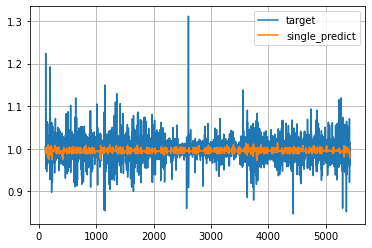

In [1249]:
df_out.plot(y=["target", "single_predict"], grid=True)

In [1250]:
df_out.head()

,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,shifted_adj_close,Adj Close Returns,SMA_50,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,Day Delta,single_predict,target
115,2001-05-18,1300.000000,1300.000000,1300.000000,1300.000000,1076.341797,54000,990165600,1076.341797,1.000000,1136.500004,69.027889,18.199103,50.828785,3.0,0.989112,0.993590
116,2001-05-21,1308.333374,1308.333374,1291.666626,1291.666626,1069.442017,48000,990424800,1076.341797,1.006452,1141.333336,66.297257,12.374777,53.922480,1.0,0.995729,1.000000
117,2001-05-22,1291.666626,1300.000000,1283.333374,1291.666626,1069.442017,102000,990511200,1069.442017,1.000000,1146.833335,63.027169,7.283751,55.743418,1.0,0.997119,1.006452
118,2001-05-23,1283.333374,1283.333374,1266.666626,1275.000000,1055.643066,126000,990597600,1069.442017,1.013072,1152.000001,57.253162,1.207796,56.045367,1.0,1.002592,1.000000
119,2001-05-24,1250.000000,1258.333374,983.333313,1041.666626,862.453491,1380000,990684000,1055.643066,1.224000,1152.500000,21.374166,-27.736960,49.111126,1.0,0.994680,1.013072


In [1346]:
naive_prediction = df_out["target"].shift(-1).to_numpy()
print(naive_prediction)

[1.         1.02739725 1.01565207 ... 1.0032     1.01461039        nan]


In [1347]:
def sign_score(listA, listB):
    if len(listA) != len(listB):
        raise "Lists must be the same length"
    return np.sum(np.where(listA*listB>0,1,0))/len(listA)
# sign_score(df["Log Returns"].to_numpy(), df["single_predict"].to_numpy())

In [1348]:
sign_score(naive_prediction-1, df_out["target"].to_numpy()-1)

0.41827468785471056

In [1345]:
sign_score(df_out["target"].to_numpy()[-100:]-1, df_out["single_predict"].to_numpy()[-100:]-1)

0.49

In [1255]:
sign_score(df_out["target"].to_numpy()-1, df_out["single_predict"].to_numpy()-1)

0.45322519803847605

In [1256]:
sign_score(df_out["target"].to_numpy()-1, df_out["single_predict"].to_numpy()+1000)

0.44907582044511507

In [1157]:
good = []
bad = []
for target, prediction in zip(df_out["target"].to_numpy(), df_out["single_predict"].to_numpy()):
    if abs(prediction-1)<0.01:
        continue
    if (target-1) * (prediction-1) > 0:
        good.append(prediction-1)
    else:
        bad.append(prediction-1)
        

In [1158]:
len(good), len(bad)

(473, 598)

In [1103]:
np.mean(np.abs(np.array(good)))

0.01392182504316889

In [1104]:
np.mean(np.abs(np.array(bad)))

0.014163332195962022

In [1105]:
len(good)/ len(good+bad)

0.45814167433302666

In [834]:
singleModel.save("model4_single")

INFO:tensorflow:Assets written to: model4_single/assets


INFO:tensorflow:Assets written to: model4_single/assets
